In [1]:
import pandas as pd
import requests
import warnings

warnings.simplefilter(action="ignore", category=FutureWarning)
import jupyter_black

jupyter_black.load()

In [2]:
raw_faction_data = requests.request(
    url="https://netrunnerdb.com/api/2.0/public/cards", method="GET"
).json()["data"]
cards_df = pd.DataFrame(raw_faction_data)
id_df = (
    cards_df[cards_df["type_code"] == "identity"]
    .groupby(["stripped_title", "faction_code"])
    .size()
    .reset_index()[["stripped_title", "faction_code"]]
)

faction_hues = {
    "shaper": "limegreen",
    "criminal": "royalblue",
    "anarch": "orangered",
    "adam": "gold",
    "jinteki": "crimson",
    "nbn": "darkorange",
    "haas-bioroid": "blueviolet",
    "weyland-consortium": "darkgreen",
}

In [3]:
def get_tournament_tables(tid: str):
    r = requests.request(url=f"https://cobr.ai/tournaments/{tid}.json", method="GET")
    raw_data = r.json()
    players = pd.DataFrame(raw_data["players"])
    elim_rankings = pd.DataFrame(raw_data["eliminationPlayers"])
    players = pd.merge(
        players, id_df, how="left", left_on="corpIdentity", right_on="stripped_title"
    ).rename(columns={"faction_code": "corpFaction"})
    players = pd.merge(
        players, id_df, how="left", left_on="runnerIdentity", right_on="stripped_title"
    ).rename(columns={"faction_code": "runnerFaction"})

    matches = pd.DataFrame(
        columns=[
            "table",
            "round",
            "id",
            "runnerScore",
            "corpScore",
            "combinedScore",
            "intentionalDraw",
            "twoForOne",
            "eliminationGame",
        ]
    )
    for rnd, tables in enumerate(raw_data["rounds"]):
        for table_number, table in enumerate(tables):
            for player in ["player1", "player2"]:
                df = pd.DataFrame([table[player]])
                df["table"] = table_number
                df["round"] = rnd
                df["twoForOne"] = table["twoForOne"]
                df["intentionalDraw"] = table["intentionalDraw"]
                df["eliminationGame"] = table["eliminationGame"]
                matches = pd.concat([matches, df], ignore_index=True)

    return matches, players, elim_rankings


def get_winrates_swiss(
    matches: pd.DataFrame,
    players: pd.DataFrame,
    n: int | None = None,
):
    if n is None or n <= 1:
        n = len(players)
    if n > len(players):
        n = len(players)
    if players is None or matches is None:
        raise ValueError("Must provide both players and matches")

    swiss_played_games = matches[
        (matches["intentionalDraw"] == False)
        & (matches["twoForOne"] == False)
        & (matches["eliminationGame"] == False)
    ]
    swiss_played_games = pd.merge(
        players.loc[: n - 1, ["id"]], swiss_played_games, how="left", on="id"
    )
    result = swiss_played_games[["runnerScore", "corpScore"]].agg("sum")
    return {
        "runner_wins": round(result["runnerScore"] / 3, 0),
        "corp_wins": round(result["corpScore"] / 3, 0),
    }


def get_winrates_cut(matches):
    elim_matches = (
        matches[(matches["eliminationGame"] == True) & matches["winner"] == True]
        .groupby("role")
        .size()
        .reset_index()
    )
    return {
        "runner_wins": elim_matches[elim_matches["role"] == "runner"][0].values[0],
        "corp_wins": elim_matches[elim_matches["role"] == "corp"][0].values[0],
    }

# AMT March

In [4]:
march_matches, march_players, march_elim = get_tournament_tables("2892")
wins = get_winrates_swiss(march_matches, march_players)
wins["runner_wins"] / (wins["runner_wins"] + wins["corp_wins"]) * 100

40.69767441860465

In [5]:
wins = get_winrates_swiss(march_matches, march_players, n=6)
wins["runner_wins"] / (wins["runner_wins"] + wins["corp_wins"]) * 100

39.285714285714285

In [6]:
swiss_played_games = march_matches[
    (march_matches["intentionalDraw"] == False)
    & (march_matches["twoForOne"] == False)
    & (march_matches["eliminationGame"] == False)
]
result = swiss_played_games[["runnerScore", "corpScore"]].agg("sum")
print(
    f"Runner Win Rate {round(result['runnerScore']/3/(result['corpScore']/3+result['runnerScore']/3)*100,1)}"
)

Runner Win Rate 40.7


In [7]:
elim_matches = (
    march_matches[
        (march_matches["eliminationGame"] == True) & march_matches["winner"] == True
    ]
    .groupby("role")
    .size()
    .reset_index()
)
elim_matches.loc[elim_matches["role"] == "corp", 0].values[0]

2

In [8]:
cut_results = get_winrates_cut(march_matches)
cut_results["runner_wins"] / (
    cut_results["runner_wins"] + cut_results["corp_wins"]
) * 100

66.66666666666666

In [9]:
may_matches, may_players, may_elim = get_tournament_tables("2980")
wins = get_winrates_swiss(may_matches, may_players)
wins["runner_wins"] / (wins["runner_wins"] + wins["corp_wins"]) * 100

34.21052631578947

In [10]:
# cut_results = get_winrates_cut(may_matches)
may_matches[(may_matches["eliminationGame"] == True) & may_matches["winner"] == True]

,table,round,id,runnerScore,corpScore,combinedScore,intentionalDraw,twoForOne,eliminationGame,role,winner
66,0,4,32765,NaN,NaN,NaN,False,False,True,corp,True
68,0,5,32769,NaN,NaN,NaN,False,False,True,corp,True


# April AMT

In [11]:
april_matches, april_players, april_elim = get_tournament_tables("2936")

In [12]:
wins = get_winrates_swiss(april_matches, april_players)
wins["runner_wins"] / (wins["runner_wins"] + wins["corp_wins"]) * 100

44.11764705882353

In [13]:
wins = get_winrates_swiss(april_matches, april_players, n=15)
wins["runner_wins"] / (wins["runner_wins"] + wins["corp_wins"]) * 100

48.529411764705884

In [14]:
cut_results = get_winrates_cut(april_matches)
cut_results["runner_wins"] / (
    cut_results["runner_wins"] + cut_results["corp_wins"]
) * 100

57.14285714285714

# APAC 2023

In [15]:
apac_matches, apac_players, apac_elim = get_tournament_tables("3080")

In [16]:
print(
    f"Total 241s: {apac_matches[apac_matches['twoForOne']][['table','round']].drop_duplicates().shape[0]}\n",
    f"Total IDs: {apac_matches[apac_matches['intentionalDraw']][['table','round']].drop_duplicates().shape[0]}",
)

Total 241s: 40
 Total IDs: 4


In [17]:
apac_matches[apac_matches["twoForOne"]]["id"].unique().shape[0] / apac_matches[
    "id"
].unique().shape[0]

0.5157894736842106

In [18]:
wins = get_winrates_swiss(apac_matches, apac_players)
wins["runner_wins"] / (wins["runner_wins"] + wins["corp_wins"]) * 100

40.66390041493776

# EMEA 2023

In [19]:
emea_matches, emea_players, emea_elim = get_tournament_tables("3102")

In [20]:
emea_matches[emea_matches["twoForOne"]][["table", "round"]].drop_duplicates().shape

(53, 2)

In [21]:
emea_matches[emea_matches["intentionalDraw"]][
    ["table", "round"]
].drop_duplicates().shape

(12, 2)

In [84]:
print(
    emea_matches[emea_matches["twoForOne"]]["id"].unique().shape[0]
    / emea_matches["id"].unique().shape[0],
)

0.5384615384615384


In [23]:
wins = get_winrates_swiss(emea_matches, emea_players)
wins["runner_wins"] / (wins["runner_wins"] + wins["corp_wins"]) * 100

44.32432432432433

In [24]:
emea_players

,id,name,rank,corpIdentity,runnerIdentity,matchPoints,strengthOfSchedule,extendedStrengthOfSchedule,stripped_title_x,corpFaction,stripped_title_y,runnerFaction
0,34194,Rustryder,1,Haas-Bioroid: Precision Design,Hoshiko Shiro: Untold Protagonist,33,3.75,3.428061224489794285714285714285714286,Haas-Bioroid: Precision Design,haas-bioroid,Hoshiko Shiro: Untold Protagonist,anarch
1,34148,bridgeman,2,Haas-Bioroid: Precision Design,Hoshiko Shiro: Untold Protagonist,33,3.433673469387754285714285714285714286,3.410787172011661428571428571428571429,Haas-Bioroid: Precision Design,haas-bioroid,Hoshiko Shiro: Untold Protagonist,anarch
2,34103,RotomAppliance,3,Azmari EdTech: Shaping the Future,"Nyusha ""Sable"" Sintashta: Symphonic Prodigy",31,3.346938775510202857142857142857142857,3.177113702623905714285714285714285714,Azmari EdTech: Shaping the Future,nbn,"Nyusha ""Sable"" Sintashta: Symphonic Prodigy",criminal
3,34057,Veronica,4,Haas-Bioroid: Precision Design,Lat: Ethical Freelancer,30,3.795918367346938571428571428571428571,3.425218658892127142857142857142857143,Haas-Bioroid: Precision Design,haas-bioroid,Lat: Ethical Freelancer,shaper
4,34193,beans,5,Asa Group: Security Through Vigilance,Arissana Rocha Nahu: Street Artist,30,3.744897959183672857142857142857142857,3.339212827988337142857142857142857143,Asa Group: Security Through Vigilance,haas-bioroid,Arissana Rocha Nahu: Street Artist,shaper
...,...,...,...,...,...,...,...,...,...,...,...,...
140,34150,saurian,141,Near-Earth Hub: Broadcast Center,Hoshiko Shiro: Untold Protagonist,0,3.857142857142857,2.7142857142857135,Near-Earth Hub: Broadcast Center,nbn,Hoshiko Shiro: Untold Protagonist,anarch
141,34173,valenhawkwing,142,The Outfit: Family Owned and Operated,"Nyusha ""Sable"" Sintashta: Symphonic Prodigy",0,2.117142857142856,2.363877551020406,The Outfit: Family Owned and Operated,weyland-consortium,"Nyusha ""Sable"" Sintashta: Symphonic Prodigy",criminal
142,34063,Girometics,143,A Teia: IP Recovery,Freedom Khumalo: Crypto-Anarchist,0,0,0,A Teia: IP Recovery,jinteki,Freedom Khumalo: Crypto-Anarchist,anarch
143,34091,CopperBoi,144,Ob Superheavy Logistics: Extract. Export. Excel.,419: Amoral Scammer,0,0,0,Ob Superheavy Logistics: Extract. Export. Excel.,weyland-consortium,419: Amoral Scammer,criminal


# Plots

In [25]:
def get_winner(corp_score, runner_score):
    if corp_score > runner_score:
        return "corp"
    elif runner_score > corp_score:
        return "runner"
    else:
        return "draw"


def get_matchup_spread(tid: str) -> pd.DataFrame:
    matches, players, elim_rankings = get_tournament_tables(tid)

    swiss_played_games = matches[
        (matches["intentionalDraw"] == False)
        & (matches["twoForOne"] == False)
        & (matches["eliminationGame"] == False)
    ]
    aug_scores = pd.merge(
        swiss_played_games[["id", "runnerScore", "corpScore", "round", "table"]],
        players[["id", "corpIdentity", "runnerIdentity"]],
        on="id",
        how="left",
    )
    aug_scores = pd.merge(
        aug_scores,
        aug_scores,
        on=["round", "table"],
        suffixes=("_left", "_right"),
    )
    aug_scores = aug_scores[aug_scores["id_left"] < aug_scores["id_right"]]
    match_dict = []
    for index, match_pair in aug_scores.iterrows():
        try:
            match_dict.append(
                {
                    "corp": match_pair["corpIdentity_left"],
                    "runner": match_pair["runnerIdentity_right"],
                    "result": get_winner(
                        match_pair["corpScore_left"], match_pair["runnerScore_right"]
                    ),
                }
            )
        except:
            print(index)
        try:
            match_dict.append(
                {
                    "corp": match_pair["corpIdentity_right"],
                    "runner": match_pair["runnerIdentity_left"],
                    "result": get_winner(
                        match_pair["corpScore_right"],
                        match_pair["runnerScore_left"],
                    ),
                }
            )
        except:
            print(index)
    matchup_spread = (
        pd.DataFrame(match_dict)
        .groupby(["corp", "runner", "result"])
        .size()
        .reset_index()
        .pivot_table(index=["corp", "runner"], columns="result", values=0)
        .fillna(0)
        .rename(columns={"corp": "corp_wins", "runner": "runner_wins", "draw": "draws"})
        .reset_index()
    )
    return matchup_spread

Text(0.5, 1.0, 'EMEA Corp Win Rates (Number is Total Decisive Games)')

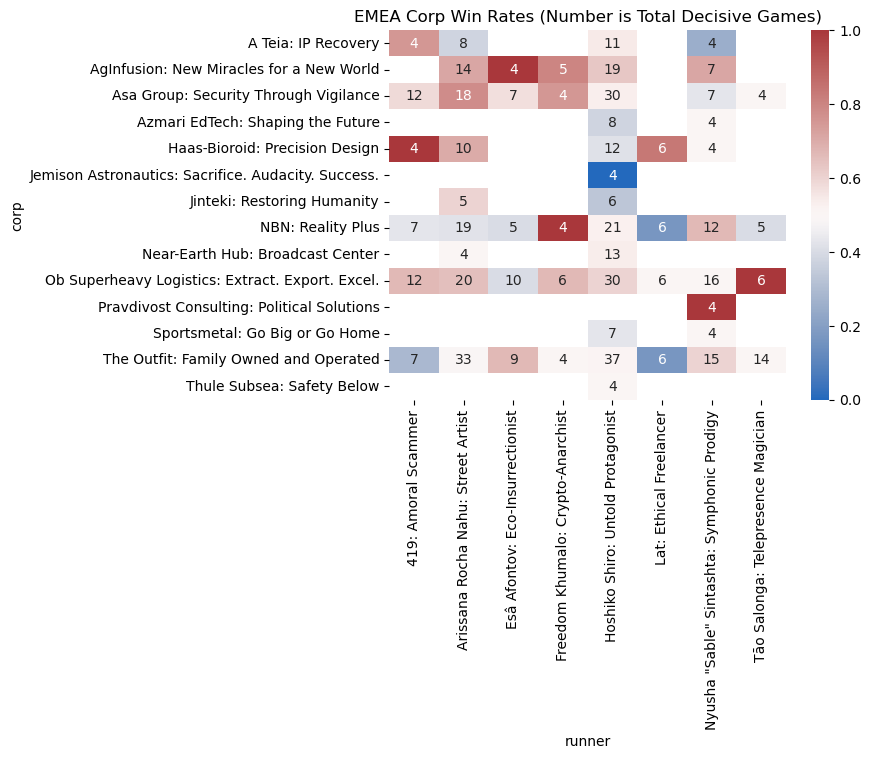

In [26]:
matchup_spread_emea = get_matchup_spread("3102")
matchup_spread_emea["corp_winrate"] = matchup_spread_emea["corp_wins"] / (
    matchup_spread_emea["corp_wins"] + matchup_spread_emea["runner_wins"]
)
matchup_spread_emea["total_games_decisive"] = (
    matchup_spread_emea["corp_wins"] + matchup_spread_emea["runner_wins"]
)


import seaborn as sns

g = sns.heatmap(
    data=matchup_spread_emea[matchup_spread_emea["total_games_decisive"] > 3].pivot(
        "corp", "runner", "corp_winrate"
    ),
    cmap="vlag",
    # annot=True,
    annot=matchup_spread_emea[matchup_spread_emea["total_games_decisive"] > 3].pivot(
        "corp", "runner", "total_games_decisive"
    ),
)
g.set_title("EMEA Corp Win Rates (Number is Total Decisive Games)")

Text(0.5, 1.0, 'EMEA Corp Win Rates (Number is Total Decisive Games)')

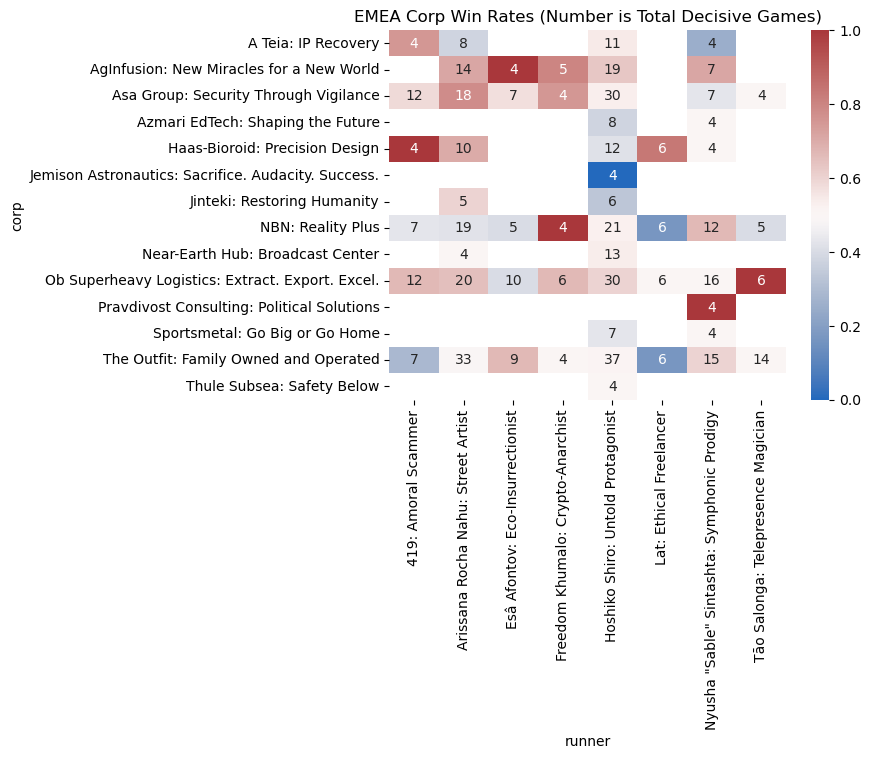

In [27]:
matchup_spread_emea = get_matchup_spread("3102")
matchup_spread_emea["corp_winrate"] = matchup_spread_emea["corp_wins"] / (
    matchup_spread_emea["corp_wins"] + matchup_spread_emea["runner_wins"]
)
matchup_spread_emea["total_games_decisive"] = (
    matchup_spread_emea["corp_wins"] + matchup_spread_emea["runner_wins"]
)


import seaborn as sns

g = sns.heatmap(
    data=matchup_spread_emea[matchup_spread_emea["total_games_decisive"] > 3].pivot(
        "corp", "runner", "corp_winrate"
    ),
    cmap="vlag",
    annot=matchup_spread_emea[matchup_spread_emea["total_games_decisive"] > 3].pivot(
        "corp", "runner", "total_games_decisive"
    ),
)
g.set_title("EMEA Corp Win Rates (Number is Total Decisive Games)")

Text(0.5, 1.0, 'APAC Corp Win Rates (Number is Total Decisive Games)')

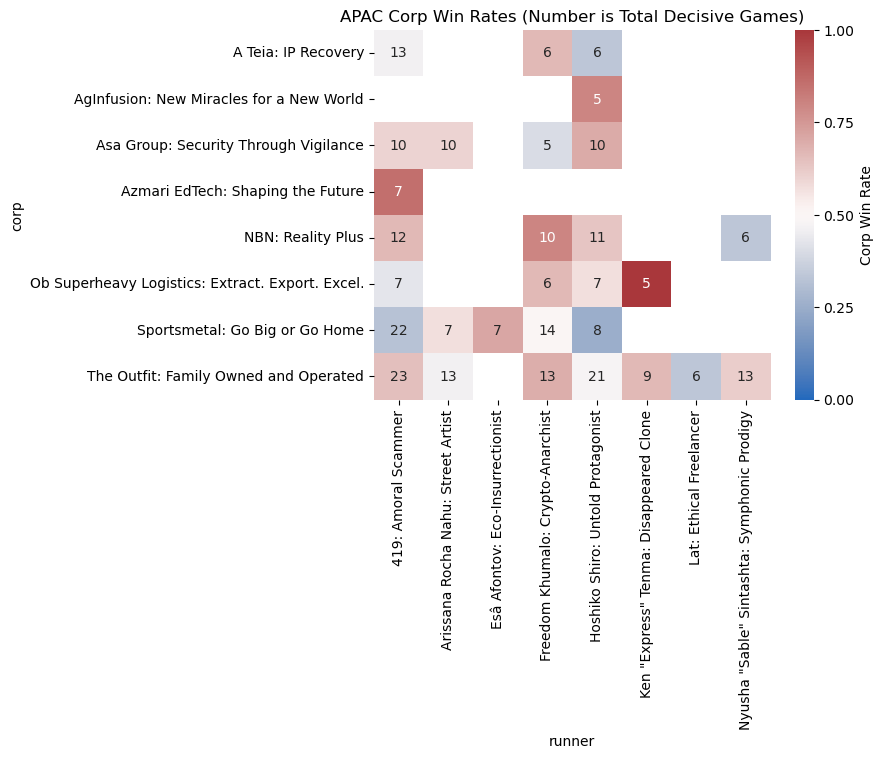

In [28]:
matchup_spread_apac = get_matchup_spread("3080")
matchup_spread_apac["corp_winrate"] = matchup_spread_apac["corp_wins"] / (
    matchup_spread_apac["corp_wins"] + matchup_spread_apac["runner_wins"]
)
matchup_spread_apac["total_games_decisive"] = (
    matchup_spread_apac["corp_wins"] + matchup_spread_apac["runner_wins"]
)


import seaborn as sns

levels = [0, 0.25, 0.5, 0.75, 1]
g = sns.heatmap(
    data=matchup_spread_apac[matchup_spread_apac["total_games_decisive"] > 4].pivot(
        "corp", "runner", "corp_winrate"
    ),
    cmap="vlag",
    annot=matchup_spread_apac[matchup_spread_apac["total_games_decisive"] > 4].pivot(
        "corp", "runner", "total_games_decisive"
    ),
    cbar_kws={"label": "Corp Win Rate", "ticks": [0, 0.25, 0.5, 0.75, 1]},
    vmin=0,
    vmax=1,
)
g.set_title("APAC Corp Win Rates (Number is Total Decisive Games)")

In [29]:
apac_players.groupby("corpIdentity").size().sort_values(ascending=False)

corpIdentity
The Outfit: Family Owned and Operated               21
Sportsmetal: Go Big or Go Home                      16
NBN: Reality Plus                                   11
Asa Group: Security Through Vigilance               10
A Teia: IP Recovery                                  7
Ob Superheavy Logistics: Extract. Export. Excel.     7
AgInfusion: New Miracles for a New World             4
Azmari EdTech: Shaping the Future                    3
Epiphany Analytica: Nations Undivided                3
Jinteki: Restoring Humanity                          3
Haas-Bioroid: Precision Design                       2
Jinteki: Personal Evolution                          2
Pravdivost Consulting: Political Solutions           2
Weyland Consortium: Built to Last                    2
Haas-Bioroid: Architects of Tomorrow                 1
dtype: int64

In [30]:
emea_players.groupby("corpIdentity").size().sort_values(ascending=False)

corpIdentity
The Outfit: Family Owned and Operated                  25
Ob Superheavy Logistics: Extract. Export. Excel.       24
Asa Group: Security Through Vigilance                  16
NBN: Reality Plus                                      16
AgInfusion: New Miracles for a New World               11
A Teia: IP Recovery                                     8
Haas-Bioroid: Precision Design                          8
Azmari EdTech: Shaping the Future                       6
Near-Earth Hub: Broadcast Center                        6
Sportsmetal: Go Big or Go Home                          5
Haas-Bioroid: Architects of Tomorrow                    3
Jinteki: Restoring Humanity                             3
Thule Subsea: Safety Below                              2
Pravdivost Consulting: Political Solutions              2
Jinteki: Personal Evolution                             2
Jemison Astronautics: Sacrifice. Audacity. Success.     2
Weyland Consortium: Built to Last                       2
S

In [35]:
matchup_spread_apac[["corp", "runner", "corp_wins", "draws", "runner_wins"]].head(1)

result,corp,runner,corp_wins,draws,runner_wins
0,A Teia: IP Recovery,419: Amoral Scammer,6.0,0.0,7.0


In [36]:
matchup_spread_emea[["corp", "runner", "corp_wins", "draws", "runner_wins"]].head(1)

result,corp,runner,corp_wins,draws,runner_wins
0,A Teia: IP Recovery,419: Amoral Scammer,3.0,0.0,1.0


Text(0.5, 1.0, 'APAC + EMEA Corp Win Rates (Number is Total Decisive Games)')

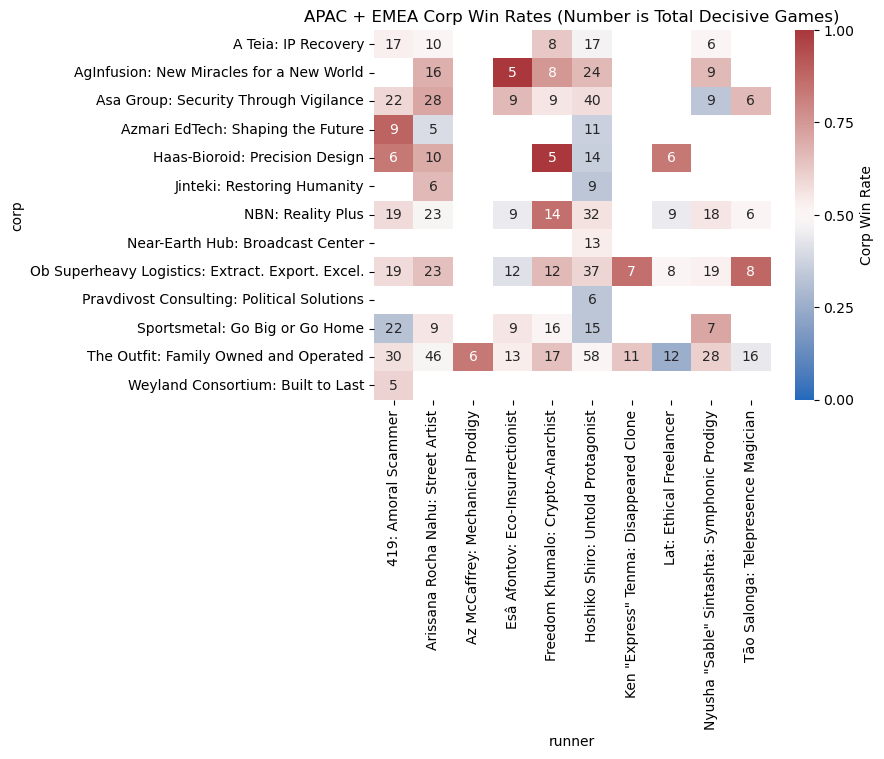

In [41]:
emea_apac_summed = (
    pd.concat(
        [
            matchup_spread_apac[
                ["corp", "runner", "corp_wins", "draws", "runner_wins"]
            ],
            matchup_spread_emea[
                ["corp", "runner", "corp_wins", "draws", "runner_wins"]
            ],
        ],
    )
    .groupby(["corp", "runner"])
    .sum()
    .reset_index()
)

emea_apac_summed["total_games_decisive"] = (
    emea_apac_summed["corp_wins"] + emea_apac_summed["runner_wins"]
)
emea_apac_summed["corp_winrate"] = (
    emea_apac_summed["corp_wins"] / emea_apac_summed["total_games_decisive"]
)
g = sns.heatmap(
    data=emea_apac_summed[emea_apac_summed["total_games_decisive"] > 4].pivot(
        "corp", "runner", "corp_winrate"
    ),
    cmap="vlag",
    annot=emea_apac_summed[emea_apac_summed["total_games_decisive"] > 4].pivot(
        "corp", "runner", "total_games_decisive"
    ),
    cbar_kws={"label": "Corp Win Rate", "ticks": [0, 0.25, 0.5, 0.75, 1]},
    vmin=0,
    vmax=1,
)
g.set_title("APAC + EMEA Corp Win Rates (Number is Total Decisive Games)")

# Cascadia

Text(0.5, 1.0, 'Cascadia Corp Win Rates (Number is Total Decisive Games)')

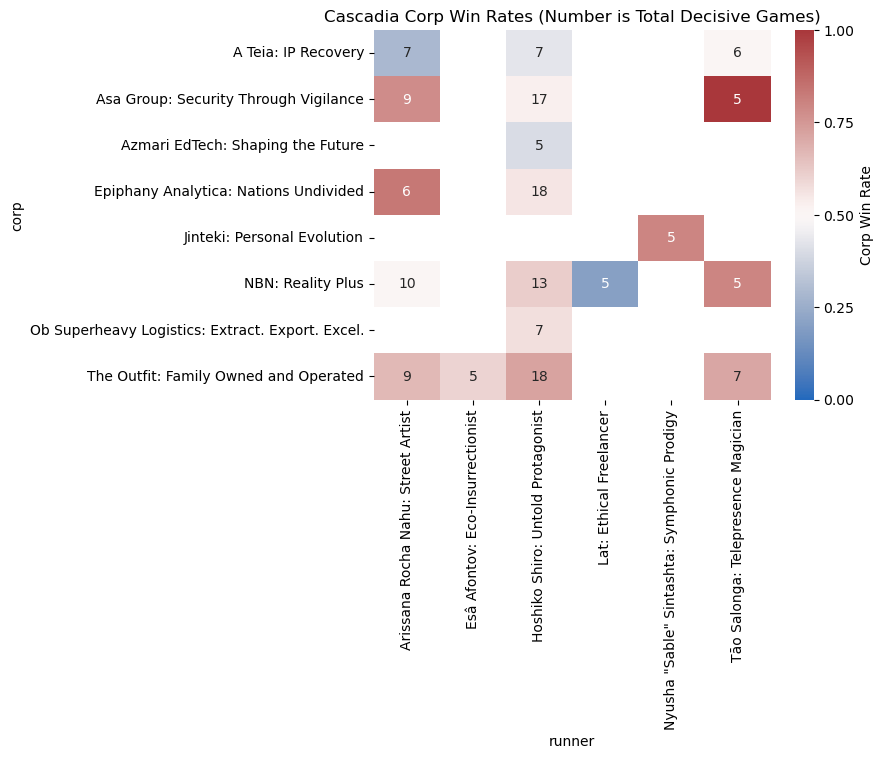

In [66]:
import json

cascadia_raw = json.load(open("64.json"))

cascadia_match_results = []
for rnd, tables in enumerate(cascadia_raw["rounds"]):
    for table_number, table in enumerate(tables):
        try:
            if table["runnerIdentity"] == "":
                continue
            cascadia_match_results.append(
                {
                    "corp": table["corpIdentity"],
                    "runner": table["runnerIdentity"],
                    "result": get_winner(table["corpScore"], table["runnerScore"]),
                }
            )
        except:
            continue
cascadia_match_results = pd.DataFrame(cascadia_match_results)
cascadia_matchup_spread = (
    cascadia_match_results.groupby(["corp", "runner", "result"])
    .size()
    .reset_index()
    .pivot_table(index=["corp", "runner"], columns="result", values=0)
    .fillna(0)
    .rename(columns={"corp": "corp_wins", "runner": "runner_wins", "draw": "draws"})
    .reset_index()
)
cascadia_matchup_spread

cascadia_matchup_spread["total_games_decisive"] = (
    cascadia_matchup_spread["corp_wins"] + cascadia_matchup_spread["runner_wins"]
)
cascadia_matchup_spread["corp_winrate"] = (
    cascadia_matchup_spread["corp_wins"]
    / cascadia_matchup_spread["total_games_decisive"]
)
g = sns.heatmap(
    data=cascadia_matchup_spread[
        cascadia_matchup_spread["total_games_decisive"] > 4
    ].pivot("corp", "runner", "corp_winrate"),
    cmap="vlag",
    annot=cascadia_matchup_spread[
        cascadia_matchup_spread["total_games_decisive"] > 4
    ].pivot("corp", "runner", "total_games_decisive"),
    cbar_kws={"label": "Corp Win Rate", "ticks": [0, 0.25, 0.5, 0.75, 1]},
    vmin=0,
    vmax=1,
)
g.set_title("Cascadia Corp Win Rates (Number is Total Decisive Games)")

In [80]:
cascadia_match_results.groupby("result").size()["corp"] / (
    cascadia_match_results.groupby("result").size()["corp"]
    + cascadia_match_results.groupby("result").size()["runner"]
)

0.5695364238410596

Text(0.5, 1.0, 'Continental Corp Win Rates (Number is Total Decisive Games)')

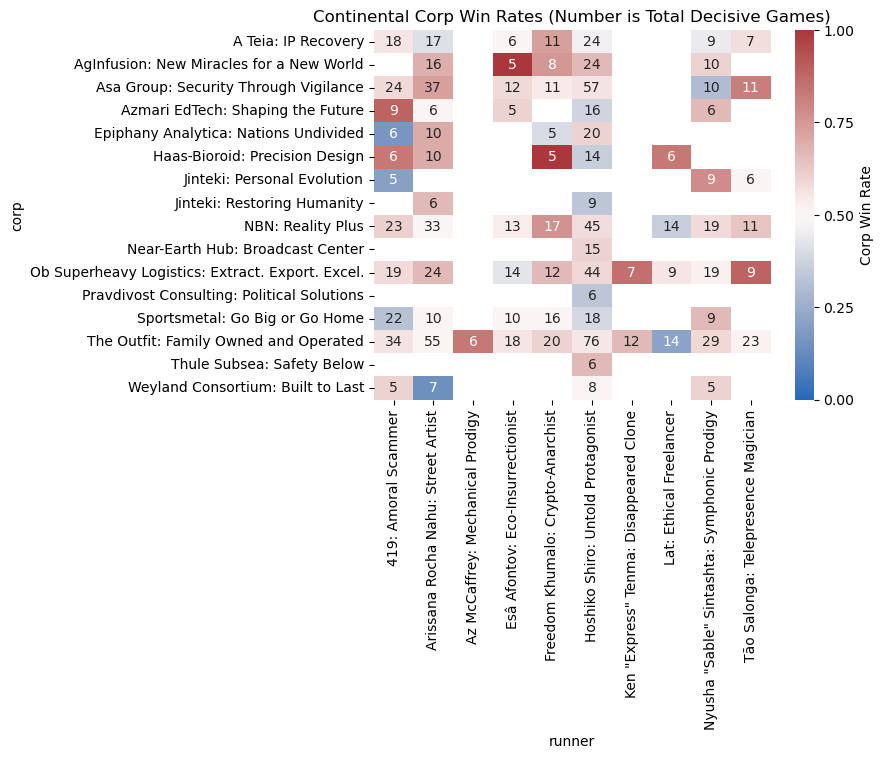

In [70]:
continentals_summed = (
    pd.concat(
        [
            matchup_spread_apac[
                ["corp", "runner", "corp_wins", "draws", "runner_wins"]
            ],
            matchup_spread_emea[
                ["corp", "runner", "corp_wins", "draws", "runner_wins"]
            ],
            cascadia_matchup_spread[
                ["corp", "runner", "corp_wins", "draws", "runner_wins"]
            ],
        ],
    )
    .groupby(["corp", "runner"])
    .sum()
    .reset_index()
)

continentals_summed["total_games_decisive"] = (
    continentals_summed["corp_wins"] + continentals_summed["runner_wins"]
)
continentals_summed["corp_winrate"] = (
    continentals_summed["corp_wins"] / continentals_summed["total_games_decisive"]
)

g = sns.heatmap(
    data=continentals_summed[continentals_summed["total_games_decisive"] > 4].pivot(
        "corp", "runner", "corp_winrate"
    ),
    cmap="vlag",
    annot=continentals_summed[continentals_summed["total_games_decisive"] > 4].pivot(
        "corp", "runner", "total_games_decisive"
    ),
    cbar_kws={"label": "Corp Win Rate", "ticks": [0, 0.25, 0.5, 0.75, 1]},
    vmin=0,
    vmax=1,
)
g.set_title("Continental Corp Win Rates (Number is Total Decisive Games)")

In [81]:
continentals_corp_stats = (
    continentals_summed.groupby("corp")
    .agg({"corp_wins": "sum", "runner_wins": "sum", "total_games_decisive": "sum"})
    .reset_index()
)
continentals_corp_stats["corp_winrate"] = (
    continentals_corp_stats["corp_wins"]
    / continentals_corp_stats["total_games_decisive"]
)
continentals_corp_stats.sort_values("corp_winrate", ascending=False)

result,corp,corp_wins,runner_wins,total_games_decisive,corp_winrate
18,SSO Industries: Fueling Innovation,5.0,1.0,6.0,0.833333
1,AgInfusion: New Miracles for a New World,55.0,21.0,76.0,0.723684
21,Thule Subsea: Safety Below,10.0,5.0,15.0,0.666667
15,Near-Earth Hub: Broadcast Center,24.0,12.0,36.0,0.666667
9,Haas-Bioroid: Precision Design,37.0,21.0,58.0,0.637931
16,Ob Superheavy Logistics: Extract. Export. Excel.,107.0,66.0,173.0,0.618497
3,Asa Group: Security Through Vigilance,110.0,69.0,179.0,0.614525
14,NBN: Reality Plus,109.0,77.0,186.0,0.586022
10,Issuaq Adaptics: Sustaining Diversity,7.0,5.0,12.0,0.583333
4,Azmari EdTech: Shaping the Future,32.0,24.0,56.0,0.571429


In [83]:
continentals_corp_stats = (
    continentals_summed.groupby("runner")
    .agg({"corp_wins": "sum", "runner_wins": "sum", "total_games_decisive": "sum"})
    .reset_index()
)
continentals_corp_stats["runner_winrate"] = (
    continentals_corp_stats["runner_wins"]
    / continentals_corp_stats["total_games_decisive"]
)
continentals_corp_stats.sort_values("runner_winrate", ascending=False)

result,runner,corp_wins,runner_wins,total_games_decisive,runner_winrate
9,Lat: Ethical Freelancer,27.0,39.0,66.0,0.590909
7,Hoshiko Shiro: Untold Protagonist,211.0,189.0,400.0,0.472500
0,419: Amoral Scammer,103.0,85.0,188.0,0.452128
5,Esâ Afontov: Eco-Insurrectionist,58.0,46.0,104.0,0.442308
2,Arissana Rocha Nahu: Street Artist,142.0,111.0,253.0,0.438735
4,Captain Padma Isbister: Intrepid Explorer,4.0,3.0,7.0,0.428571
12,"Nyusha ""Sable"" Sintashta: Symphonic Prodigy",90.0,61.0,151.0,0.403974
15,Steve Cambridge: Master Grifter,10.0,6.0,16.0,0.375000
16,Tāo Salonga: Telepresence Magician,57.0,34.0,91.0,0.373626
6,Freedom Khumalo: Crypto-Anarchist,78.0,45.0,123.0,0.365854
